# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
%%time
folder = "unbias_A/bias1/bias2/"
execute("./run_gromacs.sh",folder=folder)

In [4]:
data = load_dataframe(folder+"COLVAR")
olddata = load_dataframe("unbias_A/COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

## Adding the unbias data to the bias one
In order to use also the old data to obtain an estime on the fly of TICA cv we need to concat both data together  
The time of the bias data must be increase by the last valued of the old_data last time

In [5]:
data["time"] = data["time"] + olddata["time"].tail(1).values
data["opes.bias"] = data["opes.bias"]-min(data["opes.bias"])
newdata = pd.concat([ olddata,data],ignore_index=True).replace(np.nan, 0)

In [6]:
data = load_dataframe(folder+"COLVAR")

Text(0, 0.5, '$\\psi$')

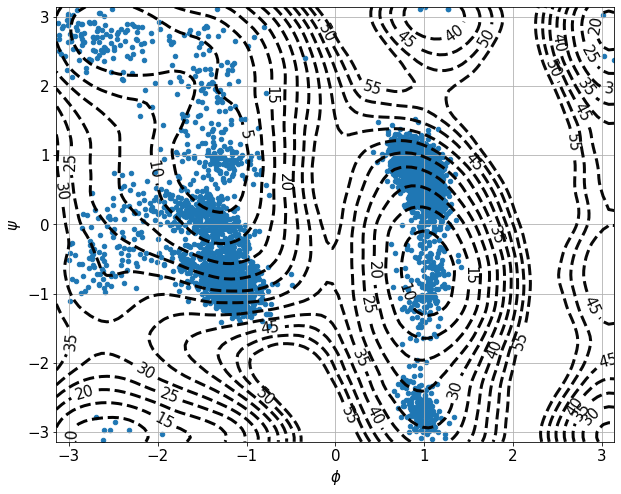

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
#load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)
data.plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

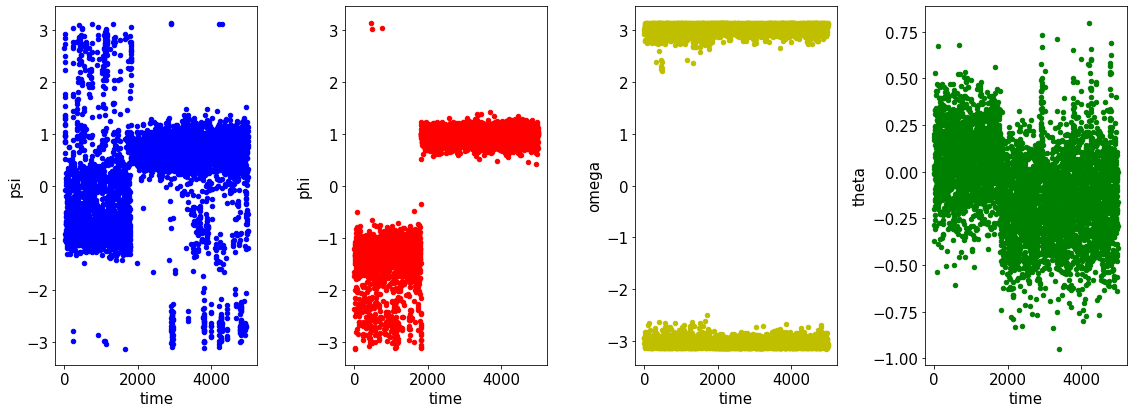

In [8]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
data.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
data.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
data.plot.scatter(x="time",y="omega",ax=axs[2], color="y")
data.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

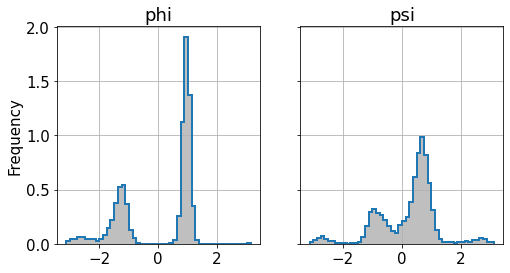

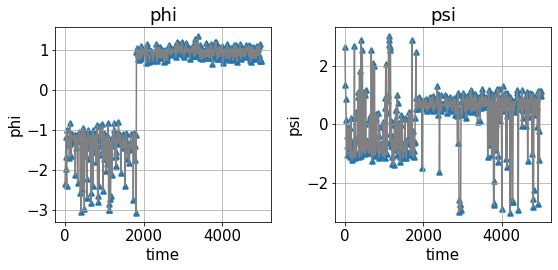

In [9]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(8,4))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [10]:
#gridspec_fes(s,logweight,sim_parameters)

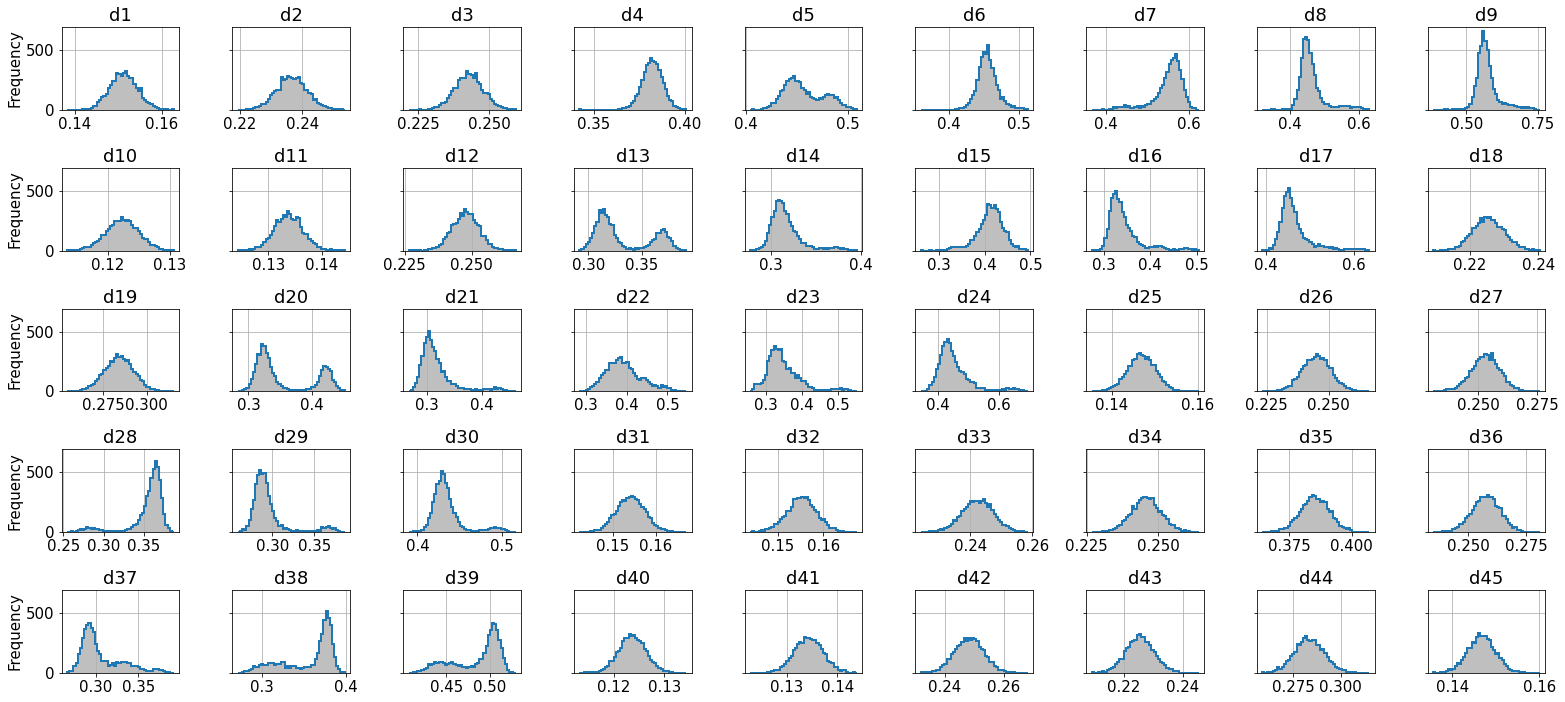

In [11]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

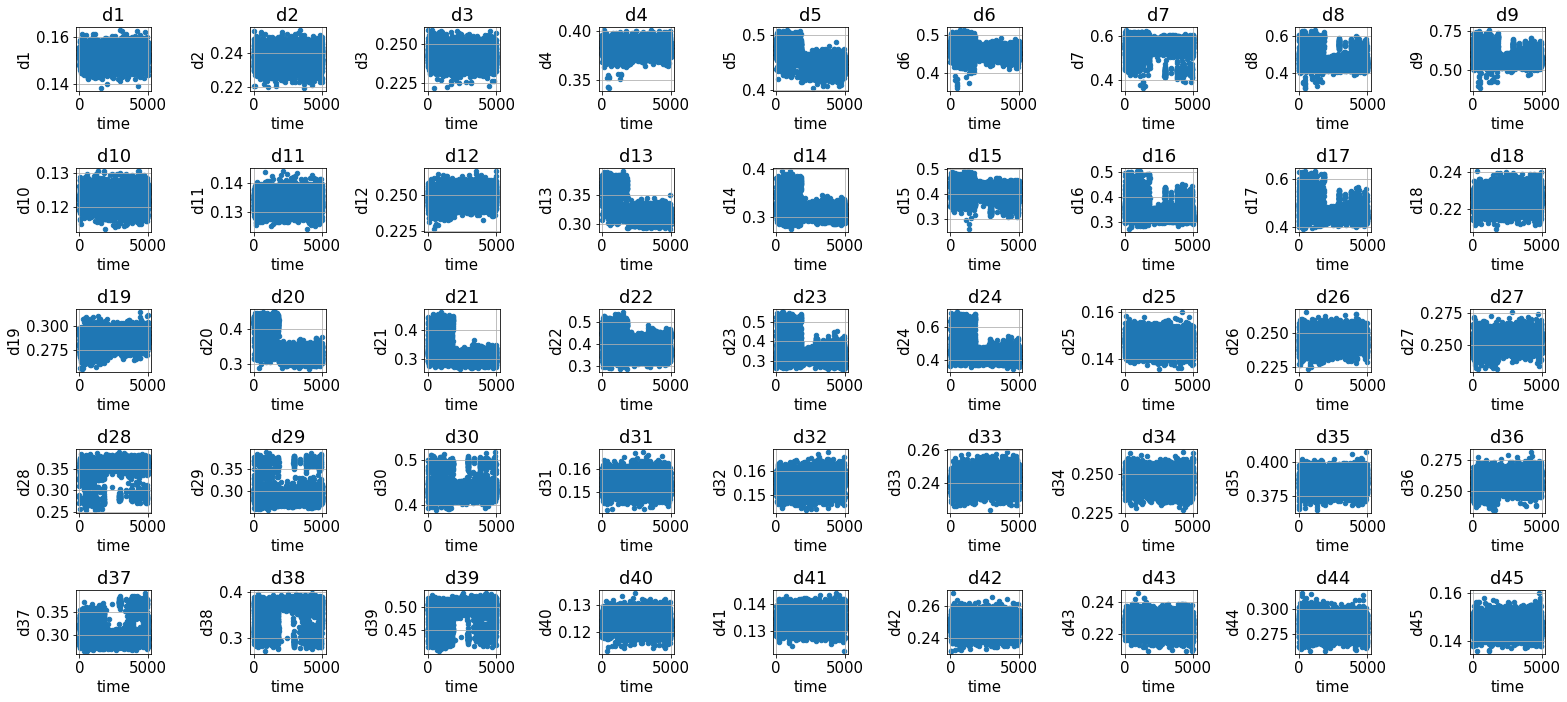

In [12]:
fig,axs = plt.subplots(5,9,figsize=(22,10))#,sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data.plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True)#,density=True)
    ax.set_title(desc)

plt.tight_layout()

<AxesSubplot:xlabel='time', ylabel='xx1'>

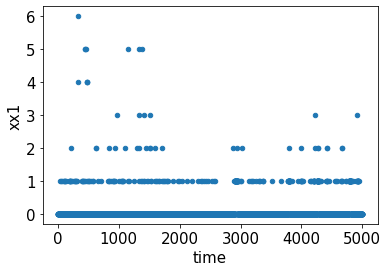

In [13]:
## plot excluded region
data.plot.scatter(x="time",y="xx1")

In [14]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':1,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": True,
              "step": 5 #se prendo tutti i valori fallisce il cholesky decomposition.. issue con pytorch
              }
#--------------------------------------#

In [15]:
'''
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values
logweights = data["opes.bias"].to_numpy()*sim_parameters["beta"]
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

lags = np.linspace(1,10,10)
timescale = np.empty(len(lags))

for i,lag in enumerate(lags):
    # TRAIN
    model.fit(X, t, lag=lag, logweights=logweights)
    #-- move the model back to cpu for convenience --# 
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
model.to('cpu')
'''

'\ndata = load_dataframe(folder+"COLVAR")\ndata = data[::train_parameters["step"]]\nX, names, t = data.filter(regex=\'^d[^a-z]\').values, data.filter(regex=\'^d[^a-z]\').columns.values, data[\'time\'].values\nlogweights = data["opes.bias"].to_numpy()*sim_parameters["beta"]\n# DEVICE\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# MODEL\nmodel = TICA_CV(n_features=X.shape[1])\nmodel.to(device)\n\nlags = np.linspace(1,10,10)\ntimescale = np.empty(len(lags))\n\nfor i,lag in enumerate(lags):\n    # TRAIN\n    model.fit(X, t, lag=lag, logweights=logweights)\n    #-- move the model back to cpu for convenience --# \n    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]\nmodel.to(\'cpu\')\n'

In [16]:
#plt.plot(lags,timescale)
#print(timescale)
#print(lags)

## DeepTICA Analysis and Export

In [17]:
torch.manual_seed(21)
data = load_dataframe(folder+"COLVAR")
data = data[:]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

# alternative method to not modify temperature but only rescale the bias
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= np.abs(min(logweight))
logweight *= sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))

#reset logweights value
logweight = ( data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )*sim_parameters["beta"]

In [18]:
# TRAIN
model.fit(X, t, lag=train_parameters["lag_time"],logweights=logweight,tprime=tprime)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
#print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2] )

eigenvalues:  [ 0.984863    0.8396776   0.6947961   0.5438009   0.41506803  0.30610743
  0.28215152  0.2545996   0.23312105  0.21214122  0.20219631  0.17581926
  0.16828555  0.16125609  0.13814181  0.13390777  0.12623957  0.10793194
  0.1025844   0.08702182  0.08343038  0.07480454  0.06541838  0.05834312
  0.04726963  0.03444415  0.02712787  0.01844453  0.01478437 -0.0016012
 -0.00795128 -0.01705572 -0.03025    -0.03581196 -0.03982558 -0.06410532
 -0.07012355 -0.08420158 -0.08938722 -0.11640728 -0.13381916 -0.1585829
 -0.1620187  -0.27363238 -0.43146363]
['tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.051582*(x0-0.151245)-0.024087*(x1-0.236584)-0.067530*(x2-0.24290

In [19]:
X = data.filter(regex=train_parameters["descriptors"]).values
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

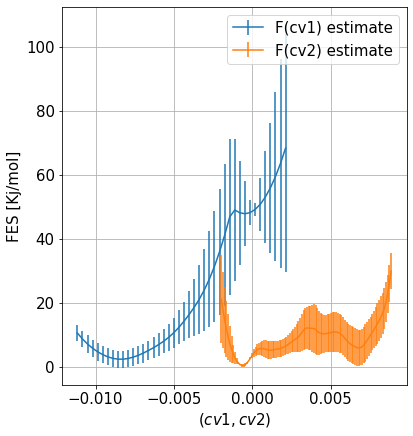

In [20]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
cvs_fes=[]
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    cvs_fes.append(fes)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

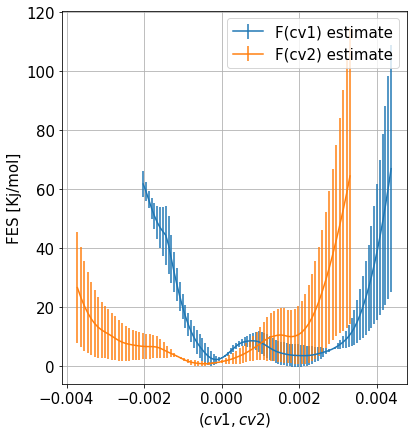

In [21]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^tica_cv").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))

for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    cvs_fes.append(fes)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

<AxesSubplot:ylabel='Frequency'>

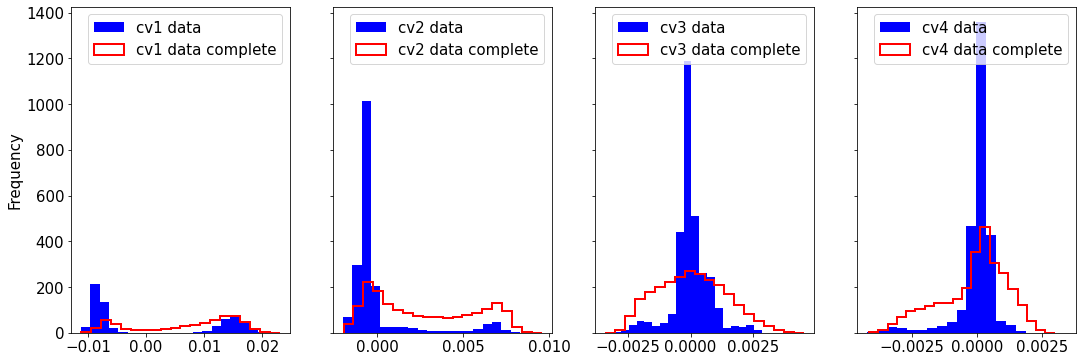

In [22]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,histtype='step',color="r",linewidth=2,label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,histtype='step',color="r",linewidth=2,label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,histtype='step',color="r",linewidth=2,label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,histtype='step',color="r",linewidth=2,label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

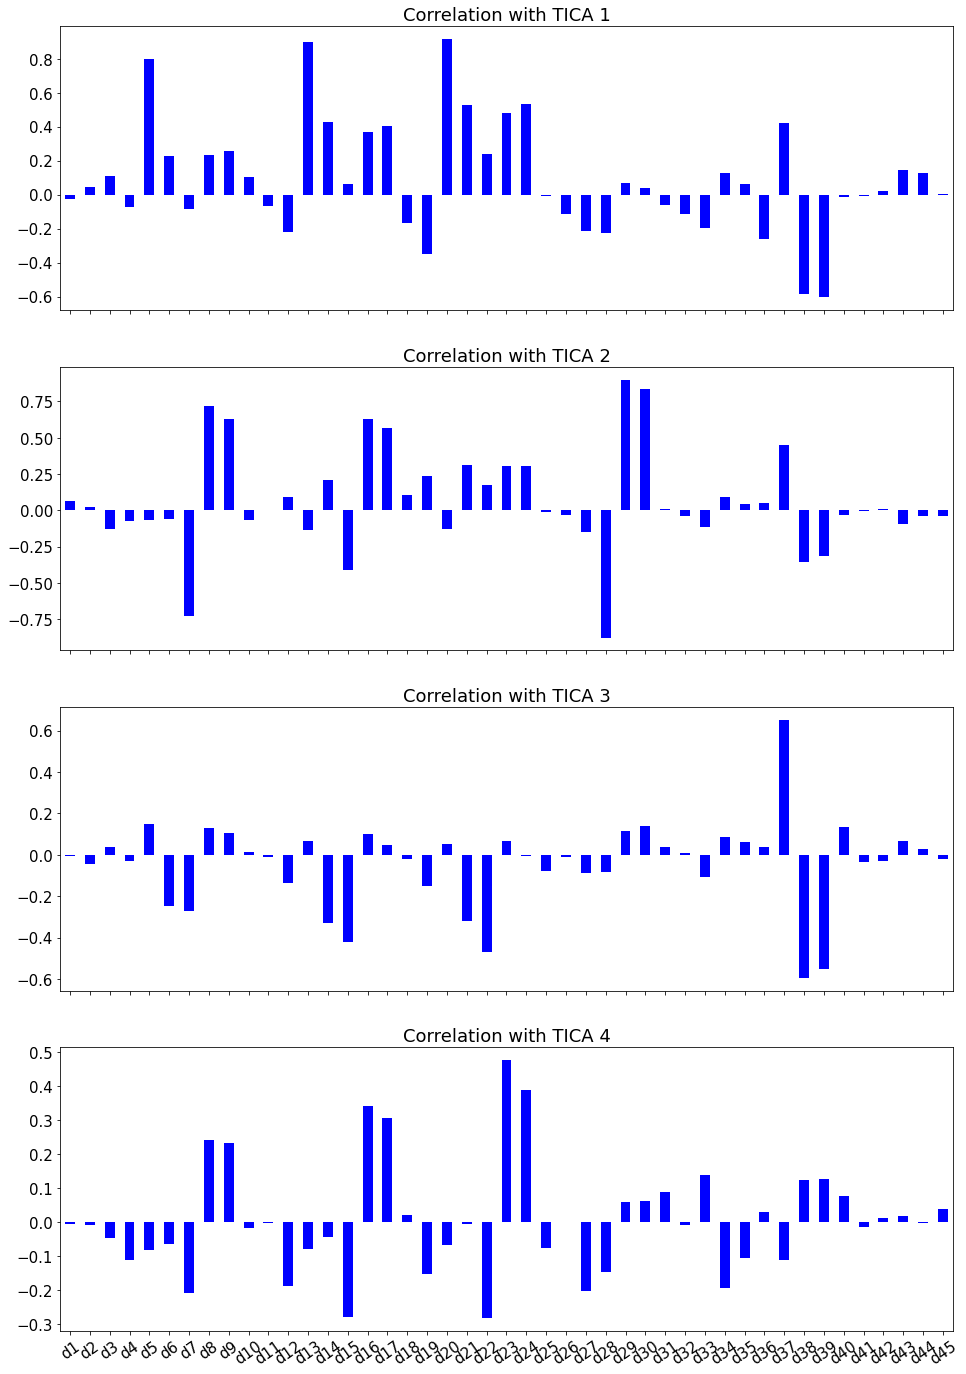

In [23]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

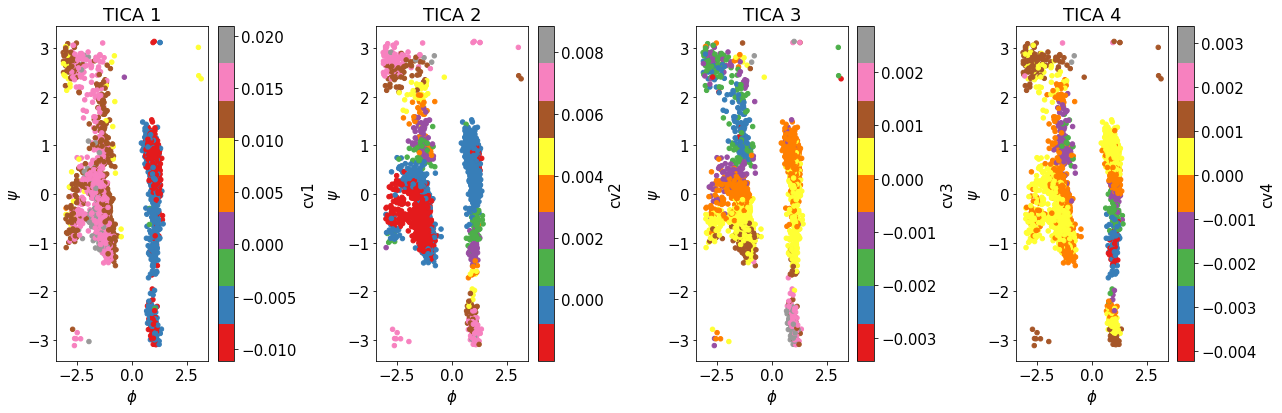

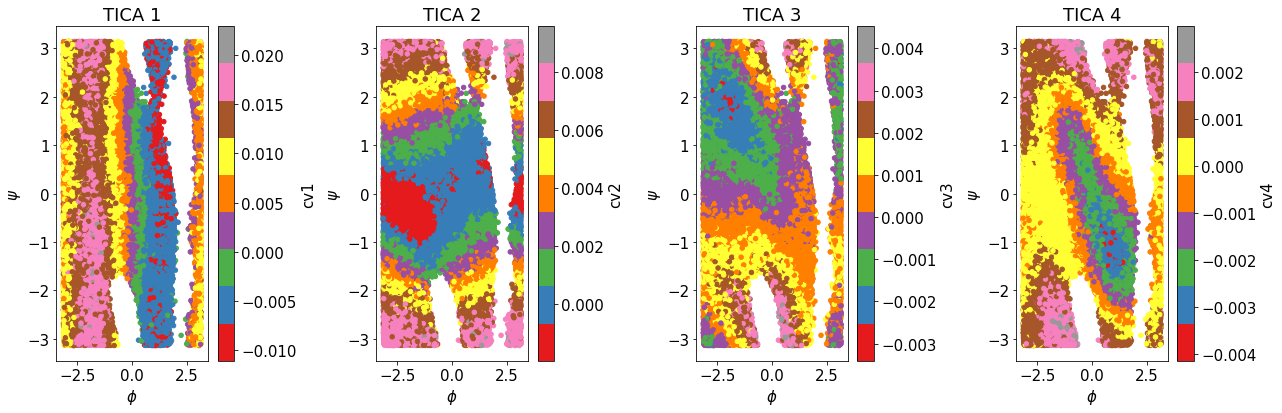

In [24]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

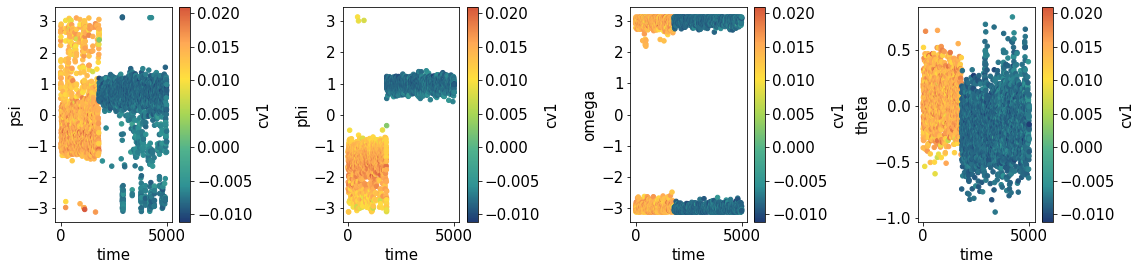

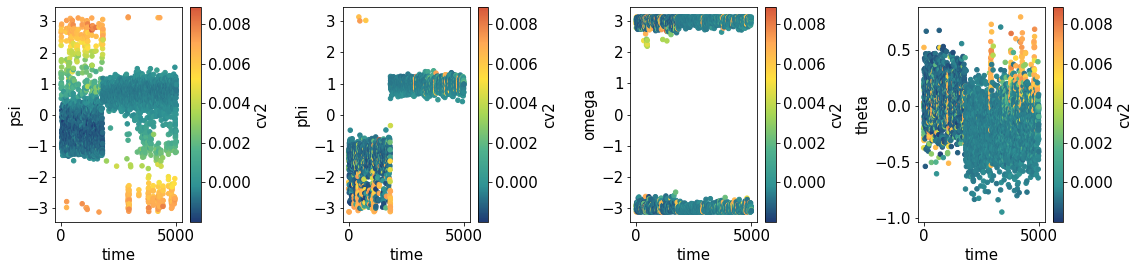

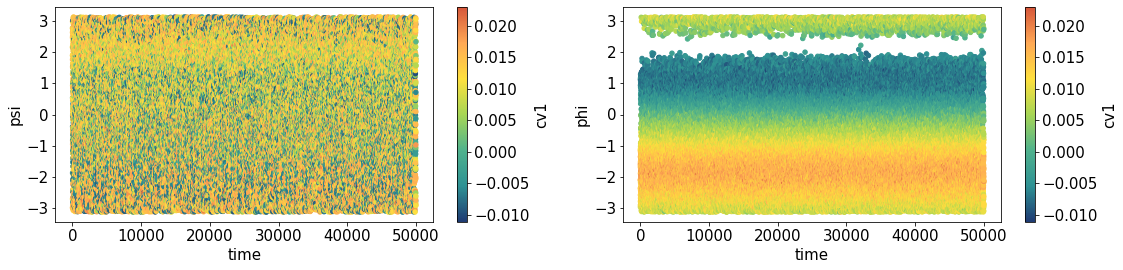

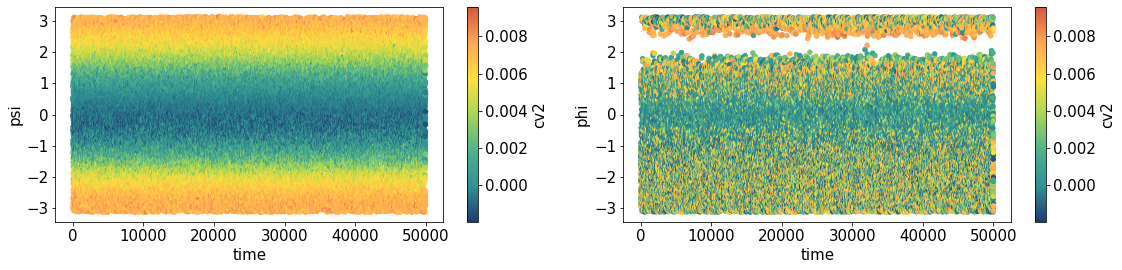

In [25]:
names = ["psi","phi","omega","theta"]
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [26]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

2.0920857937355125e-06

# Prepare the next simulation input files
### Plumed

In [27]:
## excluded region
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
excluded_region = "xx2: CUSTOM ...\n\tPERIODIC=NO\n\tARG="
for desc in descriptors_names:
    excluded_region += desc
    if desc is not descriptors_names[-1]:
        excluded_region += ","
excluded_region += "\n\tVAR="

for i in range(len(descriptors_names)):
    var = "x"+str(i)
    excluded_region += var
    if i is not len(descriptors_names)-1:
        excluded_region += ","

excluded_region += "\n\tFUNC="

for i,desc in enumerate(descriptors_names):
    func = "step((x"+str(i)+"-"+str(np.round(min(data[desc]),3))+")*(x"+str(i)+"-"+str(np.round(max(data[desc]),3))+"))"
    excluded_region += func
    if desc is not descriptors_names[-1]:
        excluded_region += "+" 

excluded_region += "\n..."

print(excluded_region)

xx2: CUSTOM ...
	PERIODIC=NO
	ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
	VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
	FUNC=step((x0-0.138)*(x0-0.163))+step((x1-0.219)*(x1-0.254))+step((x2-0.222)*(x2-0.259))+step((x3-0.342)*(x3-0.401))+step((x4-0.404)*(x4-0.509))+step((x5-0.359)*(x5-0.513))+step((x6-0.364)*(x6-0.624))+step((x7-0.319)*(x7-0.629))+step((x8-0.384)*(x8-0.759))+step((x9-0.113)*(x9-0.131))+step((x10-0.124)*(x10-0.144))+step((x11-0.226)*(x11-0.266))+step((x12-0.291)*(x12-0.391))+step((x13-0.276)*(x13-0.396))+step((x14-0.261)*(x14-0.494))+step((x15-0.273)*(x15-0.504))+step((x16-0.391)*(x16-0.636))+step((x17-0.209)*(x17-0.24))+step((x18-0.254)*(x18-0.316))+step((x19-0.283)*(x19-0.451))+step((x20-0.266)*(x20-0.46))+step((

In [31]:
folder = "unbias_A/bias1/bias2/bias3/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
tica_cv1_2"""+
model.plumed_input().splitlines()[0][8:]+"""\ntica_cv2_2"""+model.plumed_input().splitlines()[1][8:]
+"""
#excluded region
"""+
excluded_region
+"""
# bias 
opes: OPES_METAD ARG=tica_cv1_2 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

#define old_cv 0
#tica_cv1_0: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.029637*(x0-0.151295)-0.030169*(x1-0.237500)-0.040216*(x2-0.242272)-0.039141*(x3-0.381717)+0.002893*(x4-0.469097)+0.225153*(x5-0.466701)-0.117858*(x6-0.518403)-0.004963*(x7-0.519856)-0.040199*(x8-0.634493)+0.051730*(x9-0.122465)+0.078022*(x10-0.133311)+0.146658*(x11-0.247859)-0.011478*(x12-0.352353)-0.716243*(x13-0.342903)+0.393391*(x14-0.415064)+0.111528*(x15-0.393135)+0.078305*(x16-0.520782)-0.053255*(x17-0.224818)-0.038558*(x18-0.284430)+0.000293*(x19-0.395629)+0.173788*(x20-0.370787)-0.114678*(x21-0.460242)+0.011783*(x22-0.390877)-0.033371*(x23-0.515998)-0.060215*(x24-0.146723)+0.007340*(x25-0.243828)+0.264724*(x26-0.249876)-0.140306*(x27-0.311901)-0.096522*(x28-0.332600)-0.001148*(x29-0.464227)+0.031018*(x30-0.153873)+0.147623*(x31-0.154669)-0.078821*(x32-0.241675)-0.063735*(x33-0.246362)-0.003357*(x34-0.385611)-0.127734*(x35-0.256919)+0.059289*(x36-0.307312)+0.063469*(x37-0.351579)-0.013194*(x38-0.480778)+0.009924*(x39-0.123149)-0.031312*(x40-0.134079)+0.025749*(x41-0.248333)+0.037814*(x42-0.225154)-0.011917*(x43-0.283786)-0.003978*(x44-0.146422) PERIODIC=NO
#define old excluded region 0
#xx0: CUSTOM ...
#	PERIODIC=NO
#	ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
#	VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
#	FUNC=step((x0-0.141)*(x0-0.162))+step((x1-0.222)*(x1-0.256))+step((x2-0.224)*(x2-0.26))+step((x3-0.36)*(x3-0.402))+step((x4-0.402)*(x4-0.506))+step((x5-0.392)*(x5-0.517))+step((x6-0.38)*(x6-0.612))+step((x7-0.371)*(x7-0.632))+step((x8-0.484)*(x8-0.764))+step((x9-0.114)*(x9-0.13))+step((x10-0.123)*(x10-0.142))+step((x11-0.231)*(x11-0.264))+step((x12-0.297)*(x12-0.389))+step((x13-0.289)*(x13-0.394))+step((x14-0.31)*(x14-0.484))+step((x15-0.289)*(x15-0.507))+step((x16-0.403)*(x16-0.644))+step((x17-0.209)*(x17-0.239))+step((x18-0.258)*(x18-0.316))+step((x19-0.298)*(x19-0.454))+step((x20-0.285)*(x20-0.455))+step((x21-0.321)*(x21-0.531))+step((x22-0.263)*(x22-0.552))+step((x23-0.358)*(x23-0.697))+step((x24-0.137)*(x24-0.159))+step((x25-0.223)*(x25-0.265))+step((x26-0.226)*(x26-0.271))+step((x27-0.25)*(x27-0.382))+step((x28-0.266)*(x28-0.388))+step((x29-0.389)*(x29-0.524))+step((x30-0.143)*(x30-0.165))+step((x31-0.142)*(x31-0.168))+step((x32-0.225)*(x32-0.258))+step((x33-0.228)*(x33-0.262))+step((x34-0.365)*(x34-0.405))+step((x35-0.238)*(x35-0.279))+step((x36-0.259)*(x36-0.38))+step((x37-0.277)*(x37-0.399))+step((x38-0.404)*(x38-0.53))+step((x39-0.115)*(x39-0.132))+step((x40-0.124)*(x40-0.143))+step((x41-0.232)*(x41-0.265))+step((x42-0.212)*(x42-0.24))+step((x43-0.258)*(x43-0.31))+step((x44-0.136)*(x44-0.157))
#...
#static bias (previous tica_cv1)
#static0: OPES_METAD ARG=tica_cv1_0 EXCLUDED_REGION=xx0 PACE=100000000 BARRIER=40 FILE=KERNELS0 STATE_RFILE=../../RestartKernels RESTART=YES

#define old_cv 1
#tica_cv1_1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.004187*(x0-0.151312)-0.010474*(x1-0.237276)+0.001727*(x2-0.242413)-0.005270*(x3-0.381844)+0.000738*(x4-0.468484)+0.160865*(x5-0.466541)-0.099287*(x6-0.516779)-0.154358*(x7-0.520528)+0.095871*(x8-0.634897)+0.019589*(x9-0.122402)-0.020466*(x10-0.133492)+0.094141*(x11-0.247938)-0.006250*(x12-0.350874)-0.574883*(x13-0.342396)+0.342128*(x14-0.411854)+0.444493*(x15-0.395551)-0.255683*(x16-0.522578)+0.016395*(x17-0.224973)-0.047867*(x18-0.284419)+0.003516*(x19-0.392579)+0.223765*(x20-0.369959)-0.141609*(x21-0.452919)-0.148681*(x22-0.398108)+0.086524*(x23-0.522114)-0.035463*(x24-0.146876)-0.000206*(x25-0.243982)+0.217760*(x26-0.249946)-0.115618*(x27-0.312425)-0.167301*(x28-0.331463)+0.075031*(x29-0.463136)+0.006217*(x30-0.153957)+0.041787*(x31-0.154436)-0.025839*(x32-0.241326)-0.032713*(x33-0.246694)+0.018749*(x34-0.385592)-0.015700*(x35-0.255942)+0.009355*(x36-0.311146)+0.004438*(x37-0.346942)-0.003251*(x38-0.476062)+0.043781*(x39-0.123309)+0.074934*(x40-0.134362)-0.018362*(x41-0.248348)-0.028199*(x42-0.225291)+0.002675*(x43-0.283555)+0.005673*(x44-0.146326) PERIODIC=NO
#define old excluded region 1
#xx1: CUSTOM ...
#	PERIODIC=NO
#	ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
#	VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
#	FUNC=step((x0-0.141)*(x0-0.162))+step((x1-0.221)*(x1-0.256))+step((x2-0.224)*(x2-0.261))+step((x3-0.358)*(x3-0.402))+step((x4-0.399)*(x4-0.511))+step((x5-0.401)*(x5-0.515))+step((x6-0.394)*(x6-0.622))+step((x7-0.368)*(x7-0.636))+step((x8-0.463)*(x8-0.755))+step((x9-0.114)*(x9-0.131))+step((x10-0.124)*(x10-0.143))+step((x11-0.231)*(x11-0.267))+step((x12-0.292)*(x12-0.389))+step((x13-0.284)*(x13-0.395))+step((x14-0.307)*(x14-0.492))+step((x15-0.283)*(x15-0.511))+step((x16-0.38)*(x16-0.647))+step((x17-0.209)*(x17-0.24))+step((x18-0.256)*(x18-0.316))+step((x19-0.291)*(x19-0.459))+step((x20-0.271)*(x20-0.461))+step((x21-0.299)*(x21-0.536))+step((x22-0.255)*(x22-0.566))+step((x23-0.341)*(x23-0.709))+step((x24-0.135)*(x24-0.158))+step((x25-0.224)*(x25-0.266))+step((x26-0.226)*(x26-0.272))+step((x27-0.249)*(x27-0.385))+step((x28-0.265)*(x28-0.395))+step((x29-0.386)*(x29-0.517))+step((x30-0.14)*(x30-0.167))+step((x31-0.144)*(x31-0.166))+step((x32-0.225)*(x32-0.26))+step((x33-0.227)*(x33-0.269))+step((x34-0.364)*(x34-0.406))+step((x35-0.235)*(x35-0.277))+step((x36-0.26)*(x36-0.369))+step((x37-0.282)*(x37-0.397))+step((x38-0.407)*(x38-0.526))+step((x39-0.111)*(x39-0.133))+step((x40-0.126)*(x40-0.143))+step((x41-0.23)*(x41-0.266))+step((x42-0.207)*(x42-0.242))+step((x43-0.256)*(x43-0.312))+step((x44-0.135)*(x44-0.156))
#...
#static1: OPES_METAD ARG=tica_cv1_1 EXCLUDED_REGION=xx1 PACE=100000000 BARRIER=40 FILE=KERNELS0 STATE_RFILE=../RestartKernels RESTART=YES

# every 1 ps
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/bias1/bias2/bias3/


In [29]:
#!cat unbias_A/bias1/bias2/plumed.dat